# Numba: Compiling Functions

Numba’s primary use is compiling functions to fast native
machine code during runtime.

## Warning: Here lies dragons

Numba takes all the nices safety features **off**. Once the code is compiled, it's directly running assembly code. It's no safer than writing code in pure C. For instance, it's possible to corrupt memory outside your functions:

```python
@jit(nopython=True)
def this_is_evil():
    a = np.array(10)
    # Corrupts innocent memory outside the array
    a[550:600] = -999
```

This will take a chunk of memory 540 spots after where our array is and modify them. This memory could be anything and the behavior could be surprising.

So only use numba if you are ready for all the headaches that can come with it!

### An Example

Let’s consider a problem that is difficult to vectorize with numpy: generating the trajectory of a difference equation given an initial condition.

We will take the difference equation to be the quadratic map

$$
x_{t+1} = \alpha x_t (1 - x_t)
$$

Here’s the plot of a typical trajectory, starting from $ x_0 = 0.1 $, with $ t $ on the x-axis with $\alpha = 4$ypical trajectory, starting from $ x_0 = 0.1 $, with $ t $ on the x-axis

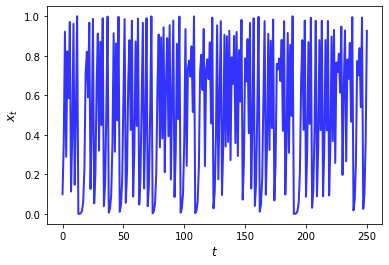

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def qm(x0, n, a=4):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
      x[t+1] = a * x[t] * (1 - x[t])
    return x

x = qm(0.1, 250)
fig, ax = plt.subplots()
ax.plot(x, 'b-', lw=2, alpha=0.8)
ax.set_xlabel('$t$', fontsize=12)
ax.set_ylabel('$x_{t}$', fontsize = 12)
plt.show()

To speed the function `qm` up using Numba, our first step is

In [2]:
from numba import jit

qm_numba = jit(qm)

The function `qm_numba` is a version of `qm` that is “targeted” for
JIT-compilation.

We will explain what this means momentarily.

Let’s time and compare identical function calls across these two versions, starting with the original function `qm`:

In [4]:
n = 100_000

%timeit qm(0.1, int(n))

95.3 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now let’s try qm_numba

In [5]:
%timeit qm_numba(0.1, int(n))

244 µs ± 730 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This kind of speed gain is huge relative to how simple and clear the implementation is.

### How and When it Works

Numba attempts to generate fast machine code using the infrastructure provided by the [LLVM Project](http://llvm.org/).

It does this by inferring type information on the fly.

The basic idea is this:

- Python is very flexible and hence we could call the function qm with many
  types.  
  
  - e.g., `x0` could be a NumPy array or a list, `n` could be an integer or a float, etc.  
  
- This makes it hard to *pre*-compile the function.

- However, when we do actually call the function, say by executing `qm(0.5, 10)`,
  the types of `x0` and `n` become clear.  

- Moreover, the types of other variables in `qm` can be inferred once the input is known.  

- So the strategy of Numba and other JIT compilers is to wait until this
  moment, and *then* compile the function.  


That’s why it is called “just-in-time” compilation.

Note that, if you make the call `qm(0.5, 10)` and then follow it with `qm(0.9, 20)`, compilation only takes place on the first call.

The compiled code is then cached and recycled as required.

### Decorator Notation

To target a function for JIT compilation we can put `@jit` before the function definition.

Here’s what this looks like for `qm`

In [ ]:
@jit(nopython=True)
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = α * x[t] * (1 - x[t])
    return x

This is equivalent to `qm = jit(qm)`.

The following now uses the jitted version:

In [ ]:
qm(0.1, 10)

### Type Inference and “nopython” Mode

Clearly type inference is a key part of JIT compilation.

As you can imagine, inferring types is easier for simple Python objects (e.g., simple scalar data types such as floats and integers).

Numba also plays well with NumPy arrays.

In an ideal setting, Numba can infer all necessary type information.

This allows it to generate native machine code, without having to call the Python runtime environment.

In such a setting, Numba will be on par with machine code from low-level languages.

When Numba cannot infer all type information, some Python objects are given generic object status and execution falls back to the Python runtime.

When this happens, Numba provides only minor speed gains or none at all.

We generally prefer to force an error when this occurs, so we know effective
compilation is failing.

This is done by using either `@jit(nopython=True)` or, equivalently, `@njit` instead of `@jit`.

For example,

In [ ]:
@jit(nopython=True)
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    return x

# Limitations

As we’ve seen, Numba needs to infer type information on
all variables to generate fast machine-level instructions.

For simple routines, Numba infers types very well.

For larger ones, or for routines using external libraries, it can easily fail.

Hence, it’s prudent when using Numba to focus on speeding up small, time-critical snippets of code.

This will give you much better performance than blanketing your Python programs with `@jit` statements.

### A Gotcha: Global Variables

Here’s another thing to be careful about when using Numba.

Consider the following example

In [ ]:
a = 1

@jit
def add_a(x):
    return a + x

print(add_a(10))

In [ ]:
a = 2

print(add_a(10))

Notice that changing the global had no effect on the value returned by the
function.

When Numba compiles machine code for functions, it treats global variables as constants to ensure type stability.